# AutoMM for Multimodal Classification with Image + Text + Tabular - Quick Start
:label:`sec_automm_multimodal_beginner`

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/neurips2022-autogluon-workshop/blob/main/notebooks/multimodal/beginner_multimodal.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/neurips2022-autogluon-workshop/blob/main/notebooks/multimodal/beginner_multimodal.ipynb)

AutoGluon Multimodal (a.k.a AutoMM) is a deep learning "model zoo" of model zoos. It can automatically build deep learning models that are suitable for multimodal datasets. You will only need to convert the data into the multimodal dataframe format
and AutoMM can predict the values of one column conditioned on the features from the other columns including images, text, and tabular data.

To start, let's install autogluon and import MultiModalPredictor. Note that you will **have to restart the runtime** if you are using Google Colab / SageMaker Studio Lab.

In [1]:
!pip install -U -q autogluon
!mim install -q mmcv-full

In [2]:
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Dataset

For demonstration, we use a simplified and subsampled version of [PetFinder dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). The task is to predict the animals' adoption rates based on their adoption profile information. In this simplified version, the adoption speed is grouped into two categories: 0 (slow) and 1 (fast).

To get started, let's download and prepare the dataset.

In [3]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

Next, we will load the CSV files.

In [4]:
import pandas as pd
dataset_path = download_dir + '/petfinder_for_tutorial'
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
label_col = 'AdoptionSpeed'

We need to expand the image paths to load them in training.

In [5]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/content/ag_automm_tutorial/petfinder_for_tutorial/images/7d7a39d71-1.jpg'

Each animal's adoption profile includes pictures, a text description, and various tabular features such as age, breed, name, color, and more. Let's look at an example row of data and display the text description and a picture.

In [6]:
example_row = train_data.iloc[0]

example_row

Type                                                             2
Name                                                 Yumi Hamasaki
Age                                                              4
Breed1                                                         292
Breed2                                                         265
Gender                                                           2
Color1                                                           1
Color2                                                           5
Color3                                                           7
MaturitySize                                                     2
FurLength                                                        2
Vaccinated                                                       1
Dewormed                                                         3
Sterilized                                                       2
Health                                                        

In [7]:
example_row['Description']

"I rescued Yumi Hamasaki at a food stall far away in Kelantan. At that time i was on my way back to KL, she was suffer from stomach problem and looking very2 sick.. I send her to vet & get the treatment + vaccinated and right now she's very2 healthy.. About yumi : - love to sleep with ppl - she will keep on meowing if she's hugry - very2 active, always seeking for people to accompany her playing - well trained (poo+pee in her own potty) - easy to bathing - I only feed her with these brands : IAMS, Kittenbites, Pro-formance Reason why i need someone to adopt Yumi: I just married and need to move to a new house where no pets are allowed :( As Yumi is very2 special to me, i will only give her to ppl that i think could take care of her just like i did (especially on her foods things).."

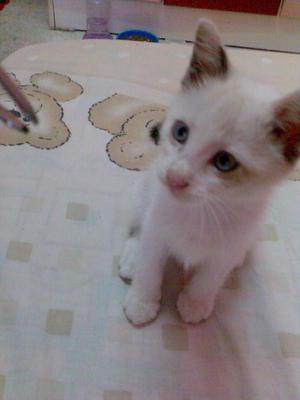

In [8]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

## Training
Now let's fit the predictor with the training data. Here we set a tight time budget for a quick demo.

In [9]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(label=label_col)
predictor.fit(
    presets="medium_quality_faster_train",
    train_data=train_data,
    time_limit=120, # seconds
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 123


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_small_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_small_patch4_window7_224.pth


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                | Params
----------------------------------------------------------
0 | model             | MultimodalFusionMLP | 63.5 M
1 | validation_metric | AUROC               | 0     
2 | loss_func         | CrossEntropyLoss    | 0     
----------------------------------------------------------
63.5 M    Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_roc_auc' reached 0.44083 (best 0.44083), saving model to '/content/AutogluonModels/ag-20221128_071841/epoch=0-step=1.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 4: 'val_roc_auc' reached 0.65097 (best 0.65097), saving model to '/content/AutogluonModels/ag-20221128_071841/epoch=0-step=4.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 5: 'val_roc_auc' reached 0.64542 (best 0.65097), saving model to '/content/AutogluonModels/ag-20221128_071841/epoch=1-step=5.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 8: 'val_roc_auc' reached 0.60389 (best 0.65097), saving model to '/content/AutogluonModels/ag-20221128_071841/epoch=1-step=8.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 9: 'val_roc_auc' was not in top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 12: 'val_roc_auc' was not in top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 13: 'val_roc_auc' reached 0.60889 (best 0.65097), saving model to '/content/AutogluonModels/ag-20221128_071841/epoch=3-step=13.ckpt' as top 3
INFO:pytorch_lightning.utilities.rank_zero:Time limit reached. Elapsed time is 0:02:07. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 13: 'val_roc_auc' was not in top 3
INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:automm:Models and intermediate outputs are saved to /content/AutogluonModels/ag-20221128_071841 


Under the hood, AutoMM automatically infers the problem type (classification or regression), detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models. If multiple backbones are available, AutoMM appends a late-fusion model (MLP or transformer) on top of them.


## Evaluation
Then we can evaluate the predictor on the test data.

In [10]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores

Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.7555999999999999}

## Prediction
Given a multimodal dataframe without the label column, we can predict the labels.

In [11]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

Predicting: 0it [00:00, ?it/s]

8     0
70    0
82    0
28    0
63    0
Name: AdoptionSpeed, dtype: int64

For classification tasks, we can get the probabilities of all classes.

In [12]:
probas = predictor.predict_proba(test_data.drop(columns=label_col))
probas[:5]

Predicting: 0it [00:00, ?it/s]

,0,1
8,0.966410,0.033590
70,0.722723,0.277277
82,0.969120,0.030880
28,0.886002,0.113998
63,0.917006,0.082994


Note that calling `.predict_proba()` on one regression task will throw an exception.


## Extract Embeddings

Extracting embeddings can also be useful in many cases, where we want to convert each sample (per row in the dataframe) into an embedding vector.

In [13]:
embeddings = predictor.extract_embedding(test_data.drop(columns=label_col))
embeddings.shape

Predicting: 0it [00:00, ?it/s]

(100, 128)

## Save and Load
It is also convenient to save a predictor and re-load it.

:::warning

`MultiModalPredictor.load()` used `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

:::

In [14]:
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-saved_model"
predictor.save(model_path)
loaded_predictor = MultiModalPredictor.load(model_path)
scores2 = loaded_predictor.evaluate(test_data, metrics=["roc_auc"])
scores2

INFO:automm:Load pretrained checkpoint: /content/tmp/8db0748e38a4414f9cd0f63bd8b7ccc9-saved_model/model.ckpt


Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.7555999999999999}

## Other Examples

You may go to [AutoMM Examples](https://github.com/awslabs/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [customization tutorial](https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html)